## Train Human Activity Recognition Model
This is based on [Human Activity Recognition](https://github.com/laxmimerit/Human-Activity-Recognition-Using-Accelerometer-Data-and-CNN) using accelerometer data. We added scripts to convert the model to TensorFlow Lite format to run the model on Microcontroller with TenserFlow Lite run time engine. 
- Convert without quantization
- Convert using float fallback quantization
- Convert using integer only quantization


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/dsettu/tflite/blob/main/har_basic/har_model.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/dsettu/tflite/blob/main/har_basic/har_model.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup Environments

In [ ]:
# Keras is TensorFlow's high-level API for deep learning
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

import os
import sys
import sklearn as sk
print(f"Tensor Flow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")
print(f"Python version: {sys.version}")
print(f"Pandas version: {pd.__version__}")
print(f"Scikit-Learn version: {sk.__version__}")
print("GPU is", "Available" if tf.test.is_gpu_available() else "Not Available")


Tensor Flow version: 2.3.0
Keras version: 2.4.0
Python version: 3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]
Pandas version: 1.1.4
Scikit-Learn version: 0.22.2.post1
GPU is Not Available


In [ ]:
# Constants for training directories and filepaths
DATASET =  'tflite/har_basic/dataset/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt'

# Constants for inference directories and filepaths
import os
MODELS_DIR = 'models'
TFLITE_DIR = 'tflite'

!rm -rf {TFLITE_DIR} {MODELS_DIR}

if not os.path.exists(MODELS_DIR):
  os.mkdir(MODELS_DIR)

!git clone -q --depth 1 https://github.com/dsettu/tflite

MODEL_TFLITE = os.path.join(MODELS_DIR, 'model.tflite')
MODEL_TFLITE_MICRO_C = os.path.join(MODELS_DIR, 'model.cpp')
MODEL_TFLITE_MICRO_H = os.path.join(MODELS_DIR, 'model.h')

MODEL_TFLITE_INT8 = os.path.join(MODELS_DIR, 'model_int8.tflite')
MODEL_TFLITE_INT8_MICRO_C = os.path.join(MODELS_DIR, 'model_int8.cpp')
MODEL_TFLITE_INT8_MICRO_H = os.path.join(MODELS_DIR, 'model_int8.h')

MODEL_TFLITE_INT8_FULL = os.path.join(MODELS_DIR, 'model_int8_full.tflite')
MODEL_TFLITE_INT8_FULL_MICRO_C = os.path.join(MODELS_DIR, 'model_int8_full.cpp')
MODEL_TFLITE_INT8_FULL_MICRO_H = os.path.join(MODELS_DIR, 'model_int8_full.h')


### Load dataset
- Remove missing and invalid data input


In [ ]:
file = open(DATASET)
lines = file.readlines()

processedList = []

for i, line in enumerate(lines):
    try:
        line=line.split(',')
        last=line[5].split(';')[0]
        last=last.strip()
        if last == '':
            print('Missing data at line number ',i)
            continue;
        temp = [line[0], line[1], line[2], line[3], line[4], last]
        processedList.append(temp)
    except:
        print('Error at line number ',i)

Error at line number  281873
Error at line number  281874
Error at line number  281875
Missing data at line number  343419
Error at line number  537501
Error at line number  832901
Error at line number  1098209


### Remove user and time information

In [ ]:
columns = ['user', 'activity', 'time','x','y','z']
data = pd.DataFrame(data=processedList, columns = columns)
print("Number of rows:", len(data.index))
data.head()


Number of rows: 1098203


,user,activity,time,x,y,z
0,33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
3,33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172
4,33,Jogging,49106332290000,-1.1849703,12.108489,7.205164


In [ ]:
df=data.drop(['user','time'], axis = 1).copy()
df.head()

,activity,x,y,z
0,Jogging,-0.6946377,12.680544,0.50395286
1,Jogging,5.012288,11.264028,0.95342433
2,Jogging,4.903325,10.882658,-0.08172209
3,Jogging,-0.61291564,18.496431,3.0237172
4,Jogging,-1.1849703,12.108489,7.205164


In [ ]:
df.shape

(1098203, 4)

### Balance the dataset equally for all activities

In [ ]:
df['activity'].value_counts()

Walking       424397
Jogging       342176
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: activity, dtype: int64

In [ ]:
Walking = df[df['activity']=='Walking'].head(48395).copy()
Jogging = df[df['activity']=='Jogging'].head(48395).copy()
Upstairs = df[df['activity']=='Upstairs'].head(48395).copy()
Downstairs = df[df['activity']=='Downstairs'].head(48395).copy()
Sitting = df[df['activity']=='Sitting'].head(48395).copy()
Standing = df[df['activity']=='Standing'].head(48395).copy()

balanced_data=pd.DataFrame()
balanced_data = balanced_data.append ([Walking, Jogging, Upstairs, Downstairs, Sitting, Standing])
balanced_data['activity'].value_counts()

Standing      48395
Downstairs    48395
Upstairs      48395
Sitting       48395
Walking       48395
Jogging       48395
Name: activity, dtype: int64

In [ ]:
balanced_data.shape

(290370, 4)

### Convert the X,Y,Z data to float 

In [ ]:
balanced_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290370 entries, 597 to 1095668
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   activity  290370 non-null  object
 1   x         290370 non-null  object
 2   y         290370 non-null  object
 3   z         290370 non-null  object
dtypes: object(4)
memory usage: 11.1+ MB


In [ ]:
balanced_data['x']=balanced_data['x'].astype('float')
balanced_data['y']=balanced_data['y'].astype('float')
balanced_data['z']=balanced_data['z'].astype('float')
balanced_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290370 entries, 597 to 1095668
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   activity  290370 non-null  object 
 1   x         290370 non-null  float64
 2   y         290370 non-null  float64
 3   z         290370 non-null  float64
dtypes: float64(3), object(1)
memory usage: 11.1+ MB


### Add label to the data

In [ ]:
balanced_data.head()

,activity,x,y,z
597,Walking,0.844462,8.008764,2.792171
598,Walking,1.116869,8.621680,3.786457
599,Walking,-0.503953,16.657684,1.307553
600,Walking,4.794363,10.760075,-1.184970
601,Walking,-0.040861,9.234595,-0.694638


In [ ]:
label=LabelEncoder()
balanced_data['label'] = label.fit_transform(balanced_data['activity'])
balanced_data.head()

,activity,x,y,z,label
597,Walking,0.844462,8.008764,2.792171,5
598,Walking,1.116869,8.621680,3.786457,5
599,Walking,-0.503953,16.657684,1.307553,5
600,Walking,4.794363,10.760075,-1.184970,5
601,Walking,-0.040861,9.234595,-0.694638,5


In [ ]:
label.classes_

array(['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
       'Walking'], dtype=object)

### Normalize the input data

In [ ]:
x = balanced_data[['x','y','z']]
y = balanced_data['label']

scaler = StandardScaler()
X = scaler.fit_transform(x)

scaled_X = pd.DataFrame(data=X, columns = ['x','y','z'])
scaled_X['label']=y.values

scaled_X.head()

,x,y,z,label
0,-0.034489,0.076967,0.266487,5
1,0.017285,0.187547,0.495750,5
2,-0.290769,1.637371,-0.075839,5
3,0.716230,0.573348,-0.650569,5
4,-0.202754,0.298127,-0.537507,5


### Convert to frames (80 samples of X, Y, Z)
- Input data is sampled at 20Hz (1 sample every 50ms)


In [ ]:
Fs = 20            # 20 samples every 1 second
frame_size = Fs*4  # 4 seconds - 80 samples
hop_size = Fs*2    # 2 seconds - 40 samples

def get_frames(df, framesize, hop_size):
    N_FEATURES = 3
    
    frames = []
    labels = []
    
    for i in range (0, len(df) - frame_size, hop_size):
        x = df['x'].values[i:i+frame_size]
        y = df['y'].values[i:i+frame_size]
        z = df['z'].values[i:i+frame_size]
        
        # Retrive the most often used label in this segment
        label = stats.mode(df['label'][i:i+frame_size])[0][0]
        frames.append([x,y,z])
        labels.append(label)
        
    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1,frame_size, N_FEATURES)
    labels = np.asarray(labels)
    
    return frames, labels


X, y = get_frames(scaled_X, frame_size, hop_size)

### Split data set for training and validation. Reshape it to use with CNN model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
X_train.shape, X_test.shape

((5806, 80, 3), (1452, 80, 3))

In [ ]:
X_train = X_train.reshape(5806,80,3,1)
X_test = X_test.reshape(1452,80,3,1)
X_train.shape, X_test.shape

((5806, 80, 3, 1), (1452, 80, 3, 1))

### Create CNN Model

In [ ]:
model = Sequential()
model.add(Conv2D(16,kernel_size=(2,2), padding='valid', activation = 'relu', input_shape=(80,3,1)))
model.add(Dropout(0.1))

model.add(Conv2D(32,kernel_size=(2,2), padding='valid', activation = 'relu'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(6,activation='softmax'))
model.summary()


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 79, 2, 16)         80        
_________________________________________________________________
dropout_24 (Dropout)         (None, 79, 2, 16)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 78, 1, 32)         2080      
_________________________________________________________________
dropout_25 (Dropout)         (None, 78, 1, 32)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 2496)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                159808    
_________________________________________________________________
dropout_26 (Dropout)         (None, 64)               

### Train Model

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(X_train, y_train, epochs =10, validation_data = (X_test, y_test), verbose=1)

Epoch 1/10
182/182 [==============================] - 2s 11ms/step - loss: 0.8976 - accuracy: 0.6314 - val_loss: 0.5136 - val_accuracy: 0.7831
Epoch 2/10
182/182 [==============================] - 2s 10ms/step - loss: 0.5577 - accuracy: 0.7668 - val_loss: 0.4289 - val_accuracy: 0.8278
Epoch 3/10
182/182 [==============================] - 2s 10ms/step - loss: 0.4526 - accuracy: 0.8164 - val_loss: 0.3442 - val_accuracy: 0.8747
Epoch 4/10
182/182 [==============================] - 2s 10ms/step - loss: 0.3757 - accuracy: 0.8481 - val_loss: 0.2975 - val_accuracy: 0.8960
Epoch 5/10
182/182 [==============================] - 2s 10ms/step - loss: 0.3268 - accuracy: 0.8657 - val_loss: 0.2801 - val_accuracy: 0.9008
Epoch 6/10
182/182 [==============================] - 2s 10ms/step - loss: 0.2989 - accuracy: 0.8770 - val_loss: 0.2352 - val_accuracy: 0.9201
Epoch 7/10
182/182 [==============================] - 2s 10ms/step - loss: 0.2632 - accuracy: 0.8968 - val_loss: 0.2310 - val_accuracy: 0.9180

### Plot Learning Curve

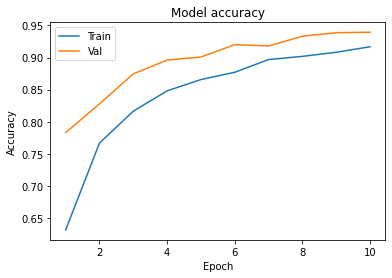

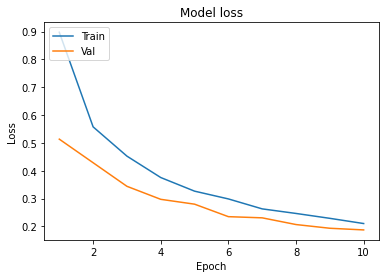

In [ ]:
def plot_learningCurve(history, epochs):
    # Plot training & validation accuracy values
    epoch_range = range(1, epochs+1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
    # Plot training & validation loss values
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

plot_learningCurve(history, 10)

### Plot Confusion Matrix

In [ ]:
!pip install mlxtend

(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fed95b273c8>)

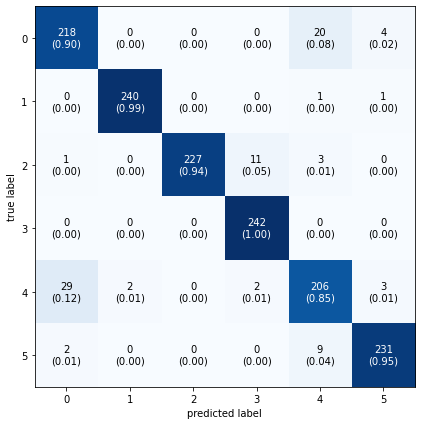

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib

y_pred = np.argmax(model.predict(X_test), axis=-1) 
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, show_normed=True, figsize=(7,7))

### Convert to a TensorFlow Lite model - without quantization


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

open(MODEL_TFLITE, "wb").write(tflite_model)


INFO:tensorflow:Assets written to: /tmp/tmp7icvikfv/assets


INFO:tensorflow:Assets written to: /tmp/tmp7icvikfv/assets


652120

(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fed95a41c88>)

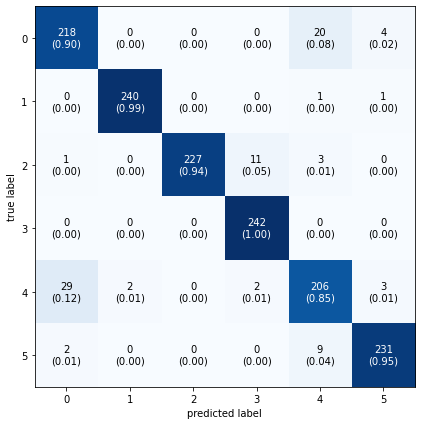

In [ ]:
# Initialize an interpreter with the model
interpreter = tf.lite.Interpreter(MODEL_TFLITE)

# Allocate memory for the model's input Tensor's
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]


# Create arrays to store the results
har_model_predictions = []

# Inference with Tensorflow Lite model
for i in range(len(X_test)):
  input = X_test[i].reshape(1,80,3,1)
  input = input.astype(np.float32)

  x_value_tensor = tf.convert_to_tensor(input, dtype=tf.float32)
  interpreter.set_tensor(input_index, x_value_tensor)
  interpreter.invoke()
  har_model_predictions.append(interpreter.get_tensor(output_index)[0])

# Plot Confusion matrix
y_pred=np.argmax(har_model_predictions, axis=1)
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, show_normed=True, figsize=(7,7))

### Convert to a TensorFlow Lite model - using float fallback quantization

In [ ]:
def representative_dataset_gen():
    for i in range(len(X_train)):
      input = X_train[i].reshape(1,80,3,1)
      input = input.astype(np.float32)
      yield [input]
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# This sets the representative dataset for quantization
converter.representative_dataset = representative_dataset_gen

tflite_model_int8 = converter.convert()

open(MODEL_TFLITE_INT8, "wb").write(tflite_model_int8)

INFO:tensorflow:Assets written to: /tmp/tmpnxzijaio/assets


INFO:tensorflow:Assets written to: /tmp/tmpnxzijaio/assets


168096

(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fed9490fcf8>)

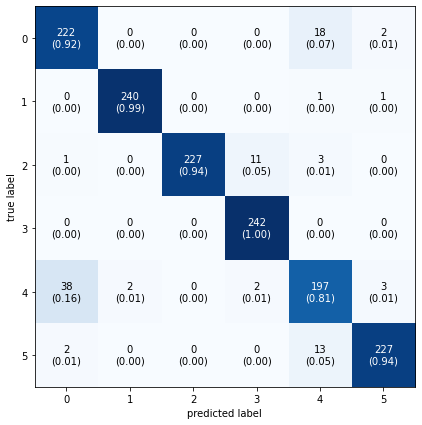

In [ ]:
# Initialize an interpreter with the model
interpreter = tf.lite.Interpreter(MODEL_TFLITE_INT8)

# Allocate memory for the model's input Tensor's
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]


# Create arrays to store the results
har_model_predictions = []

# Inference with Tensorflow Lite model
for i in range(len(X_test)):
  input = X_test[i].reshape(1,80,3,1)
  input = input.astype(np.float32)

  #x_value_tensor = tf.convert_to_tensor(input, dtype=tf.float32)
  interpreter.set_tensor(input_index, input)
  interpreter.invoke()
  har_model_predictions.append(interpreter.get_tensor(output_index)[0])

# Plot Confusion matrix
y_pred=np.argmax(har_model_predictions, axis=1)
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, show_normed=True, figsize=(7,7))

### Convert to a TensorFlow Lite model - using integer-only quantization

In [ ]:
def representative_dataset_gen():
    for i in range(len(X_train)):
      input = X_train[i].reshape(1,80,3,1)
      input = input.astype(np.float32)
      yield [input]

converter=tf.lite.TFLiteConverter.from_keras_model(model)
# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# This sets the representative dataset for quantization
converter.representative_dataset = representative_dataset_gen

# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# For full integer quantization, though supported types defaults to int8 only, 
# we explicitly declare it for clarity.
converter.target_spec.supported_types = [tf.int8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8
# Provide a representative dataset to ensure we quantize correctly.
tflite_model_int8_full = converter.convert()

open(MODEL_TFLITE_INT8_FULL, "wb").write(tflite_model_int8_full)

INFO:tensorflow:Assets written to: /tmp/tmp_jk1rwrk/assets


INFO:tensorflow:Assets written to: /tmp/tmp_jk1rwrk/assets


167840

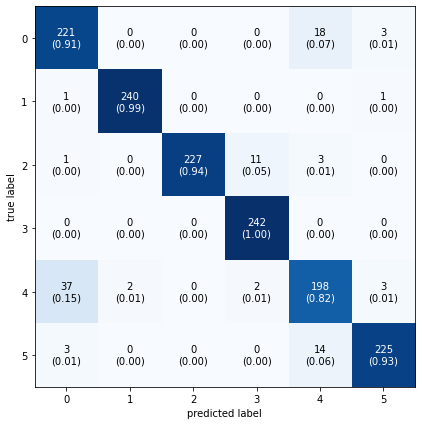

In [ ]:
# Initialize an interpreter with the model
interpreter = tf.lite.Interpreter(MODEL_TFLITE_INT8_FULL)

# Allocate memory for the model's input Tensor's
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

# Create arrays to store the results
har_model_predictions = []

# Inference with Tensorflow Lite model
for i in range(len(X_test)):
  tf_input = X_test[i].reshape(1,80,3,1)
  tf_input = tf_input.astype(np.float32)

# Manually quantize the input from float to integer
  scale, zero_point = input_details['quantization']
  tflite_integer_input = tf_input / scale + zero_point
  tflite_integer_input = tflite_integer_input.astype(input_details['dtype'])
  interpreter.set_tensor(input_details['index'], tflite_integer_input)

  interpreter.invoke()

  output_details = interpreter.get_output_details()[0]
  tflite_integer_output = interpreter.get_tensor(output_details['index'])
  # Manually dequantize the output from integer to float
  scale, zero_point = output_details['quantization']
  tflite_output = tflite_integer_output.astype(np.float32)
  tflite_output = (tflite_output - zero_point) * scale

  har_model_predictions.append(tflite_output[0])

# Plot Confusion matrix
y_pred=np.argmax(har_model_predictions, axis=1)
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, show_normed=True, figsize=(7,7))
plt.show()

### Generate C file

In [ ]:
from tensorflow.lite.python.util import convert_bytes_to_c_source
source_text, header_text = convert_bytes_to_c_source(tflite_model,  "har_model")

with  open(MODEL_TFLITE_MICRO_H,  'w')  as  file:
    file.write(header_text)

with  open(MODEL_TFLITE_MICRO_C,  'w')  as  file:
    file.write(source_text)

In [ ]:
from tensorflow.lite.python.util import convert_bytes_to_c_source
source_text, header_text = convert_bytes_to_c_source(tflite_model_int8,  "har_model")

with  open(MODEL_TFLITE_INT8_MICRO_H,  'w')  as  file:
    file.write(header_text)

with  open(MODEL_TFLITE_INT8_MICRO_C,  'w')  as  file:
    file.write(source_text)

In [ ]:
from tensorflow.lite.python.util import convert_bytes_to_c_source
source_text, header_text = convert_bytes_to_c_source(tflite_model_int8_full,  "har_model")

with  open(MODEL_TFLITE_INT8_FULL_MICRO_H,  'w')  as  file:
    file.write(header_text)

with  open(MODEL_TFLITE_INT8_FULL_MICRO_C,  'w')  as  file:
    file.write(source_text)